# Building a simple feed forward or convolutional2D neural-network with Keras

**Author: Xavier Snelgrove**

This is a simple quick-start in performing digit recognition in a neural network in Keras, for a short tutorial at the University of Toronto.

It is largely based on the `mnist_mlp.py` example from the Keras source.

Source: https://github.com/wxs/keras-mnist-tutorial.git


# Loading the data and setting up the environment

## Let's start!

Specify some details for running the network:




In [0]:
#model_flag = 'FullyConnected' # Choose between 'FullyConnected' or 'Conv2D'
model_flag = 'Conv2D' # Choose between 'FullyConnected' or 'Conv2D'
epochs = 4 # Number of epochs to train the network
batch_size = 128 # Number of samples used for one weight update
if model_flag not in ['FullyConnected', 'Conv2D']:
  raise ValueError('wrong model chosen: %s'%model_flag)

First let's import some libraries and set the environment

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

from keras.datasets import mnist #mnist dataset (and many more) are available online
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

try:
  import pydot
  from keras_sequential_ascii import sequential_model_to_ascii_printout
except ImportError:
  print('>>>> Restart from the top because pydot was just installed <<<<')
  !pip install -q keras_sequential_ascii
  !apt-get -qq install -y graphviz && pip install -q pydot >/dev/null 2>&1
  import os, signal
  os.kill(os.getpid(), signal.SIGKILL)

Found GPU at: /device:GPU:0


## Load training data

In [5]:
nb_classes = 10 # number of classes. Here digits 0-9, so 10 classes

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

11493376/11490434 [==============================] - 3s 0us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Let's look at some examples of the training data

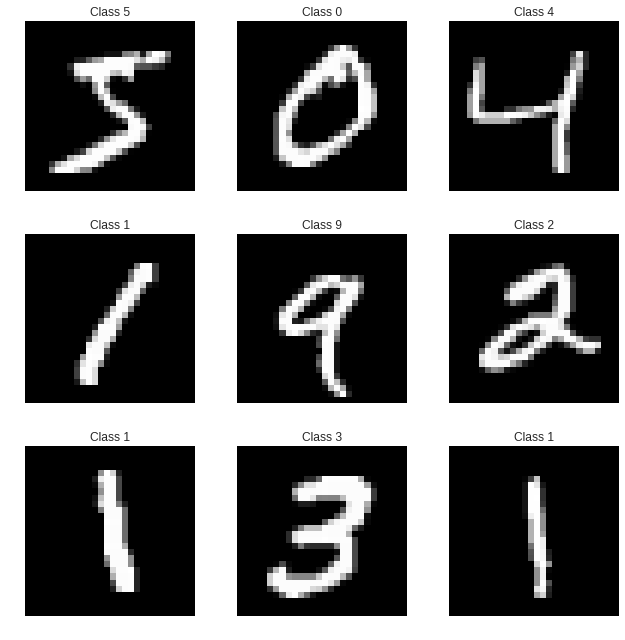

In [6]:
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))
    plt.axis('off')
plt.tight_layout()

## Format the data for training
We need to reshape the input tensor (image) so that it fits the neural network.

The fully connected neural network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector. 

The convolutional neural network is going to take the 28x28 image for each training example, but we need to add an 'color' axis. In our case (grayscale) its length is 1 whereas for a RGB image it would have a length of 3.

We'll also scale the inputs to be in the range [0-1] rather than [0-255]

In [7]:
if model_flag == 'FullyConnected':
  X_train = X_train.reshape(60000, 784)
  X_test = X_test.reshape(10000, 784)
elif model_flag == 'Conv2D':
  X_train = X_train[...,np.newaxis]
  X_test = X_test[...,np.newaxis]
else: raise ValueError('wrong model chosen: %s'%model_flag)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


The classifier's output expects matrices to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
9 -> [0, 0, 0, 0, 0, 0, 0, 0, 1]
```

In [0]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Build the neural network
Build the neural-network. Here we'll do a simple layer fully connected network or a simple convolutional neural network (decision was made above)
Below we visualize the network architecture in different ways

In [9]:
def fully_connected_model():
  model = Sequential()
  model.add(Dense(64, input_shape=(784,)))  #Fully connected layer with 64 neurons
                                            #Only the 1st layer need to know the input shape
  model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                                # of the layer above. Here, with a "rectified linear unit", meaning f(x)=max(0,x)

  model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
                            # by disconnecting a fraction (here 20%) of random connections during training
  model.add(Dense(128))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10))
  model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                   # ensures the output is a valid probaility distribution, that is
                                   # that its values are all non-negative and sum up to 1.
  return model

def convolutional2D_model():
  model = Sequential()

  # CONVOLUTION PART
  model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 1)))  #Convolution2D layer with a kernel size (receptive field) of 3x3 pixel
                                                                      #and 16 kernel, resulting in 16 different feature maps  
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #Pooling layer that decreases the dimension of the layers by
                                             #combining the outputs of neuron clusters (here 2x2) at one layer 
                                             #into a single neuron in the next layer that receives 
                                             #the maximum value of the outputs cluster.
  model.add(Dropout(0.2))
  
  model.add(Conv2D(32, kernel_size=(3, 3)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  # REGRESSION PART
  model.add(Flatten()) #(N x N x 32) is flattened to by a 1D vector of length N*N*32
  model.add(Dense(20))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  
  return model

if model_flag == 'FullyConnected':
  model = fully_connected_model()
elif model_flag == 'Conv2D':
  model = convolutional2D_model()
else: raise ValueError('wrong model chosen: %s'%model_flag)
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 32)        0         
__________

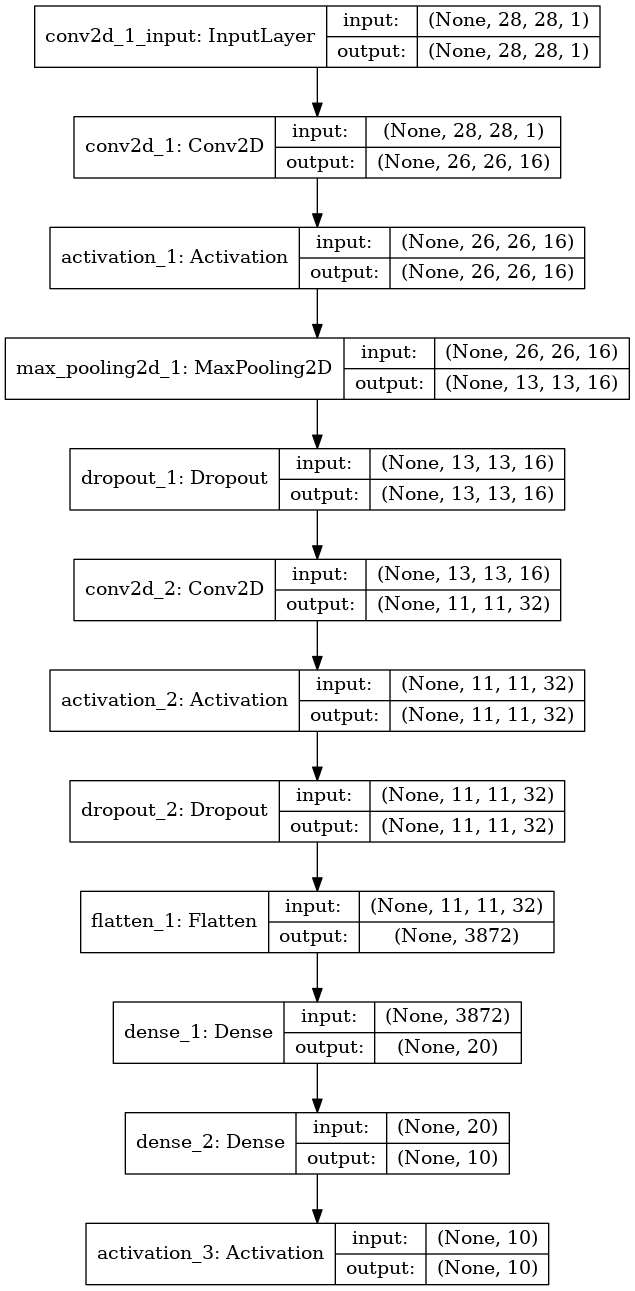

In [10]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)
Image('plot_model.png', height=600)

In [11]:
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.2%
                relu   #####     26   26   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     13   13   16
             Dropout    | || -------------------         0     0.0%
                       #####     13   13   16
              Conv2D    \|/  -------------------      4640     5.6%
                relu   #####     11   11   32
             Dropout    | || -------------------         0     0.0%
                       #####     11   11   32
             Flatten   ||||| -------------------         0     0.0%
                       #####        3872
               Dense   XXXXX -------------------     77460    93.9%
                       #####          20
               Dense   XXXXX -------------------       210     0.3%
             softmax   #

## Compile the model
Keras is built on top of  the TensorFlow library (and Theano as well), both packages that allow you to define a *computation graph* in Python, which they then compile and run efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiling a model, Keras asks you to specify your **loss function** and your **optimizer** and optionally a **metric**. The loss function is the function that is minimized during training by an suitable algorithm given by the optimizer. The loss function we'll use here is called *categorical crossentropy*, and is a loss function well-suited to comparing two probability distributions. The metric is similar to the loss function but this value is just monitorred and not minimized. The optimizer helps determine how quickly the model learns, how resistent it is to getting "stuck" or "blowing up". We won't discuss this in too much detail, but "adam" is often a good choice.

Here our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0% for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)



In [0]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Train the model!
This is the fun part: you can feed the training data loaded above into this model and it will learn to classify digits

In [13]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 117us/step - loss: 0.2924 - acc: 0.9108 - val_loss: 0.0948 - val_acc: 0.9702
Epoch 2/4
60000/60000 [==============================] - 6s 96us/step - loss: 0.0912 - acc: 0.9725 - val_loss: 0.0556 - val_acc: 0.9830
Epoch 3/4
60000/60000 [==============================] - 6s 96us/step - loss: 0.0699 - acc: 0.9787 - val_loss: 0.0431 - val_acc: 0.9853
Epoch 4/4
60000/60000 [==============================] - 6s 96us/step - loss: 0.0579 - acc: 0.9821 - val_loss: 0.0419 - val_acc: 0.9868


## Finally, evaluate the model performance
The model is trained. Let's check the final loss and accuracy on test sample of course!
Then, we look into the training curve (loss) and the accuracy curve.
This information is directly provided by the training method.

In [14]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.04193029027627781
Test accuracy: 0.9868


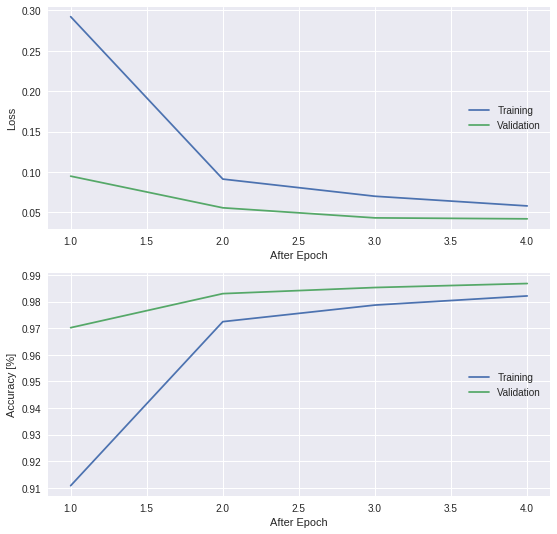

In [15]:
epochs = np.arange(1,len(history.history['acc'])+1)

plt.figure()
plt.subplot(2,1,1)
plt.plot(epochs, history.history['loss'], label='Training')
plt.plot(epochs, history.history['val_loss'], label='Validation')
plt.xlabel('After Epoch')
plt.ylabel('Loss')
plt.legend(loc='center right')

plt.subplot(2,1,2)
plt.plot(epochs, history.history['acc'], label='Training')
plt.plot(epochs, history.history['val_acc'], label='Validation')
plt.xlabel('After Epoch')
plt.ylabel('Accuracy [%]')
plt.legend(loc='center right')

### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [0]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

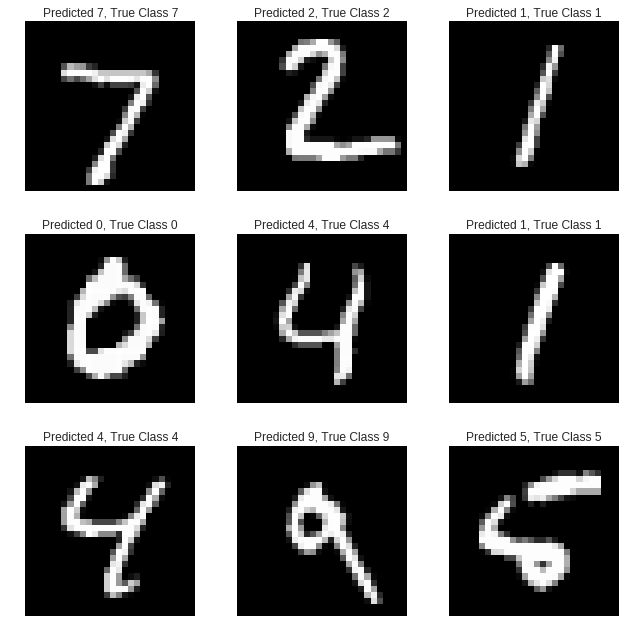

In [17]:
#Let's plot some CORRECT samples
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, True Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.axis('off')
plt.tight_layout()

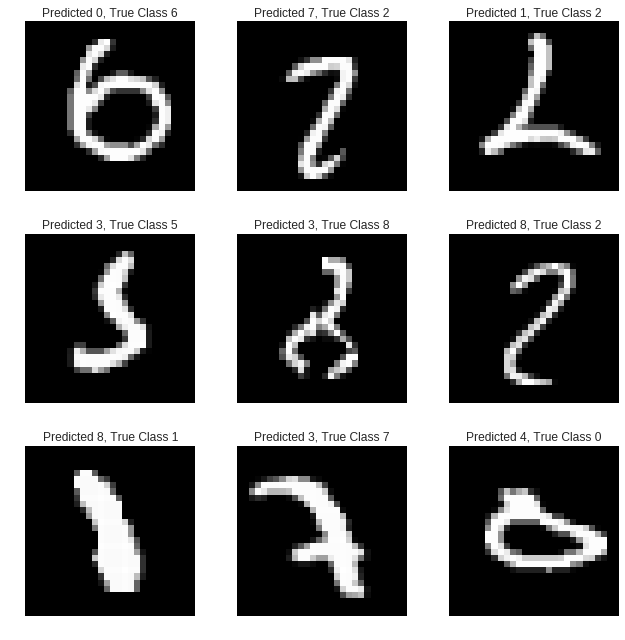

In [18]:
#Let's plot some WRONG samples
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, True Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.axis('off') 
plt.tight_layout()

# That's all!

There are lots of other great examples at the Keras homepage at http://keras.io and in the source code at https://github.com/fchollet/keras